In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import toolz
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import datetime

from glob import glob

import pandas as pd
from tqdm.notebook import tqdm

try:
    dir_changed
except:
    os.chdir('..')
    dir_changed = True

import config as cfg
import src.utils as utils

from src.loaders import CSVLoader

In [3]:
loader = CSVLoader()

In [4]:
from src.add_features import CorrelationFinder, FeatureManager, VarianceCalculator, OutlierFinder

In [5]:
fm = FeatureManager(machine_id='WOS 176L')

/home/ubuntu/anaconda3/envs/audioburst/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
from src.models import LGBM

In [105]:
tt = fm.loader.get_all_data()["last"]
ttt = fm.loader.get_all_data()["middle"]

In [107]:
true_data = [data.fillna(method="bfill").fillna(0).drop(columns="ENGHOURS").values.reshape(1,-1)[0] for data in utils.get_time_grouped_data(tt, freq="600s").tail(1000).rolling(window=50)]

max_len = max([len(data) for data in true_data])

true_data = [data for data in true_data if len(data) == max_len]

true_labels = np.ones(len(true_data))

In [110]:
false_data = [data.fillna(method="bfill").drop(columns="ENGHOURS").fillna(0).values.reshape(1,-1)[0] for data in utils.get_time_grouped_data(ttt, freq="600s").tail(1000).rolling(window=50)]

max_len = max([len(data) for data in false_data])

false_data = [data for data in false_data if len(data) == max_len]

false_labels = np.zeros(len(false_data))

In [111]:
all_data = np.stack(true_data + false_data)
all_labels = np.concatenate((true_labels, false_labels))

In [112]:
all_labels.shape

(1902,)

In [113]:
all_data.shape

(1902, 1150)

In [114]:
from sklearn.model_selection import train_test_split

In [115]:
X_train, X_val, y_train, y_val = train_test_split(all_data, all_labels, test_size=0.2)

In [116]:
model = LGBM()

In [117]:
best_params = model.find_best_params(X_train, y_train, X_val, y_val)

In [119]:
model.train(X_train, y_train, best_params)

In [123]:
preds = model.predict(X_val)

In [124]:
(preds == y_val).mean()

0.931758530183727

In [125]:
model.trained_model.feature_importances_

array([ 3, 13,  0, ...,  0,  0,  0], dtype=int32)

In [126]:
import lightgbm

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

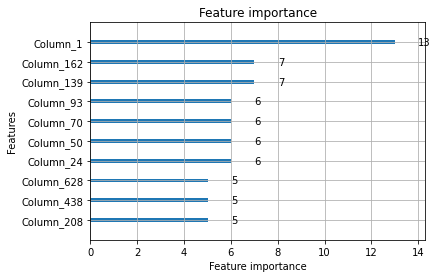

In [127]:
lightgbm.plot_importance(model.trained_model, max_num_features=10)